# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes
from funcoes.graficos import plotar_graficos, grid_graficos, grid_graficos_estacoes
from funcoes.estacao_ano import estacao_do_ano
from funcoes.funcoes_gerais import trocar_temp, preparar_df_long_com_ponderada
from funcoes.funcoes_teste import treinamento_media_simples, treinamento_ponderado_por_zona_e_hora, treinamento_por_weather_zone_e_hora_cv
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# credencias
api_key = '41ac637ac7464f6da57351ed3fa5e5ff'
start_date = "2023-09-01"
end_date = "2024-09-01"

# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [3]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [4]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]


In [5]:
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Dia da semana

In [6]:
df_dia_semana = df.copy()
df_dia_semana['publish_time_utc_carga'] = pd.to_datetime(df_dia_semana['publish_time_utc_carga'])
df_dia_semana['dia'] = df_dia_semana['publish_time_utc_carga'].dt.day_name()
df_dia_semana['ano']= df_dia_semana['publish_time_utc_carga'].dt.year
df_dia_semana['mes']= df_dia_semana['publish_time_utc_carga'].dt.month

df_dia_semana.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dia_semana['estacao'] = df_dia_semana['publish_time_utc_carga'].apply(estacao_do_ano)


In [7]:
df.columns

Index(['interval_start_utc', 'interval_end_utc', 'publish_time_utc_carga',
       'coast_carga', 'east_carga', 'far_west_carga', 'north_carga',
       'north_central_carga', 'south_central_carga', 'southern_carga',
       'west_carga', 'system_total', 'sum_load', 'publish_time_utc_tf',
       'coast_tf', 'east_tf', 'far_west_tf', 'north_tf', 'north_central_tf',
       'south_central_tf', 'southern_tf', 'west_tf', 'hour', 'weekday',
       'avg_temp_fahrenheit', 'coast_tc', 'east_tc', 'far_west_tc', 'north_tc',
       'north_central_tc', 'south_central_tc', 'southern_tc', 'west_tc',
       'avg_temp_celsius'],
      dtype='object')

# Graficos de temperatura por estacao do ano

In [ ]:
# Lista apenas com colunas de temperatura em Celsius
regioes_tc = [
    'coast_tc', 'east_tc', 'far_west_tc',
    'north_tc', 'north_central_tc', 'south_central_tc',
    'southern_tc', 'west_tc', 'avg_temp_celsius'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_tc):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_tc', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Temperatura (°C)')
    axes[i].legend(title='Estação', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Temperatura por Região e Estação (°C)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Graficos de carga por estacao do ano

NameError: name 'df_dia_semana' is not defined

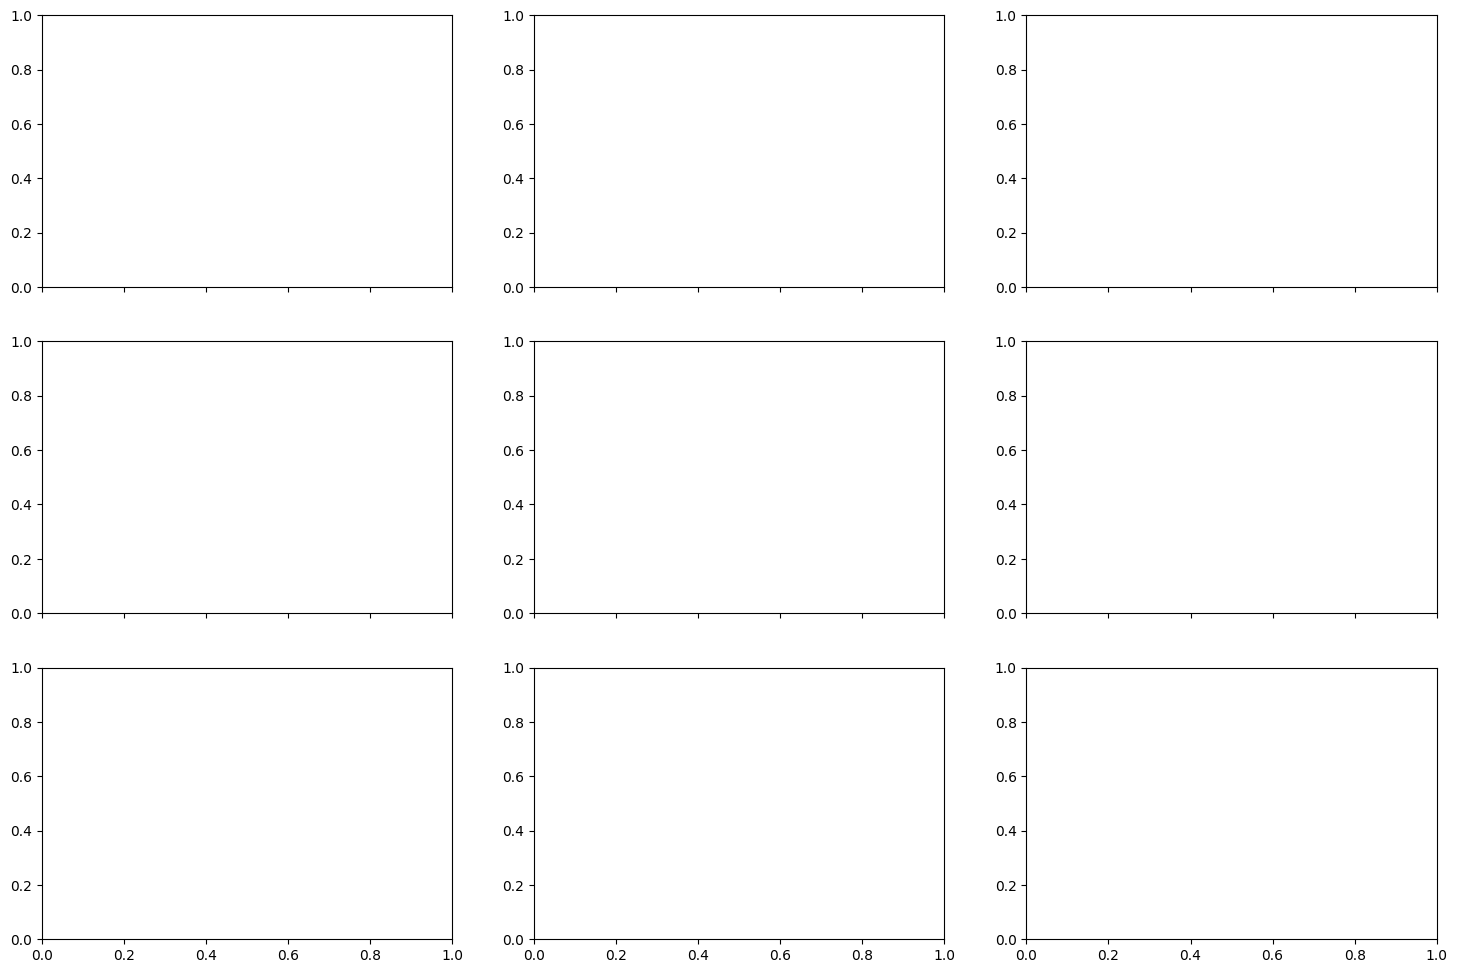

In [80]:
# Lista com os nomes das 9 regiões (colunas de carga)
regioes_carga = [
    'coast_carga', 'east_carga', 'far_west_carga',
    'north_carga', 'north_central_carga', 'south_central_carga',
    'southern_carga', 'west_carga', 'system_total'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_carga):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_carga', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Carga Média (MW)')
    axes[i].legend(title='Estação', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Carga por Região e Estação (MW)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Comparativo entre temperatura vs carga ambos por estacao

In [ ]:
def comparar_temp_carga_estacoes(df, regiao_tc):
    regiao_nome = regiao_tc.replace('_tc', '')
    regiao_carga = f'{regiao_nome}_carga'

    # Agrupar dados por estação e hora
    df_temp = df.groupby(['estacao', 'hour'])[regiao_tc].mean().reset_index()
    df_carga = df.groupby(['estacao', 'hour'])[regiao_carga].mean().reset_index()

    estacoes = sorted(df['estacao'].dropna().unique())

    # Criar figura com 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

    # --- Gráfico de Temperatura ---
    sns.lineplot(data=df_temp, x='hour', y=regiao_tc, hue='estacao', palette='tab10', ax=axs[0])
    # axs[0].set_title(f'Temperatura por Estação - {regiao_nome.title()}')
    axs[0].set_xlabel('Hora')
    axs[0].set_ylabel('Temperatura (°C)')
    axs[0].grid(True)

    # --- Gráfico de Carga ---
    sns.lineplot(data=df_carga, x='hour', y=regiao_carga, hue='estacao', palette='tab10',dashes=True, ax=axs[1])
    # axs[1].set_title(f'Carga por Estação - {regiao_nome.title()}')
    axs[1].set_xlabel('Hora')
    axs[1].set_ylabel('Carga (MW)')
    axs[1].grid(True)

    # Ajuste da legenda
    axs[1].legend_.remove()  # Remove legenda duplicada
    axs[0].legend( fontsize='small')

    # Layout final
    plt.suptitle(f'Comparativo Temperatura x Carga - {regiao_nome.title()}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


comparar_temp_carga_estacoes(df_dia_semana, 'far_west_tc')

In [10]:
tabela_equacoes(df = df , n_weekday = 1)

,Hora,avg_temp_celsius,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc
0,0,y = 89.36x² -2424.62x + 55507.53,y = 25.74x² -737.48x + 15144.30,y = 3.50x² -101.87x + 2086.66,y = 2.14x² -52.82x + 6473.50,y = 2.19x² -48.88x + 1436.16,y = 29.17x² -807.08x + 15670.57,y = 16.20x² -423.32x + 8838.45,y = 9.16x² -287.16x + 5187.07,y = 1.95x² -53.86x + 1466.04
1,1,y = 89.65x² -2440.69x + 54394.81,y = 24.83x² -715.94x + 14761.71,y = 3.30x² -96.25x + 2002.96,y = 2.20x² -52.84x + 6439.73,y = 2.12x² -47.71x + 1405.28,y = 29.53x² -821.44x + 15325.52,y = 15.90x² -414.88x + 8500.17,y = 9.18x² -287.08x + 5048.38,y = 2.00x² -56.14x + 1460.57
2,2,y = 88.05x² -2391.05x + 53296.77,y = 23.05x² -653.19x + 14054.07,y = 3.32x² -98.18x + 1993.72,y = 2.10x² -46.66x + 6362.85,y = 2.11x² -47.76x + 1383.65,y = 28.97x² -802.85x + 14956.93,y = 15.37x² -402.99x + 8339.19,y = 8.79x² -274.18x + 4868.89,y = 1.96x² -55.03x + 1435.67
3,3,y = 87.43x² -2365.74x + 52880.95,y = 22.58x² -639.24x + 13937.15,y = 3.25x² -96.84x + 1980.81,y = 1.99x² -42.78x + 6319.51,y = 2.05x² -46.71x + 1380.41,y = 29.54x² -813.88x + 14892.72,y = 14.85x² -390.29x + 8254.68,y = 8.56x² -265.23x + 4763.10,y = 1.95x² -54.87x + 1424.98
4,4,y = 87.37x² -2371.47x + 53486.75,y = 21.92x² -619.26x + 13980.40,y = 3.26x² -98.64x + 2034.75,y = 1.98x² -41.48x + 6295.49,y = 2.05x² -46.83x + 1392.46,y = 29.03x² -803.35x + 15059.83,y = 14.02x² -368.99x + 8242.93,y = 8.79x² -277.89x + 4934.11,y = 1.94x² -54.96x + 1437.70
5,5,y = 87.18x² -2406.62x + 55868.94,y = 22.07x² -636.67x + 14735.61,y = 3.24x² -100.47x + 2147.52,y = 1.85x² -39.58x + 6306.06,y = 1.91x² -44.66x + 1446.71,y = 28.97x² -818.37x + 15980.37,y = 13.09x² -350.17x + 8558.41,y = 8.40x² -268.61x + 5037.75,y = 1.83x² -53.15x + 1482.30
6,6,y = 82.09x² -2335.92x + 59186.51,y = 20.27x² -596.45x + 15296.55,y = 2.92x² -95.19x + 2298.57,y = 1.62x² -35.68x + 6374.58,y = 1.78x² -43.38x + 1543.62,y = 26.40x² -769.20x + 17075.07,y = 12.63x² -359.13x + 9401.66,y = 7.64x² -250.78x + 5266.55,y = 1.69x² -52.10x + 1590.34
7,7,y = 80.11x² -2305.72x + 60753.66,y = 21.27x² -639.93x + 16021.37,y = 2.84x² -93.57x + 2351.84,y = 1.35x² -28.75x + 6364.89,y = 1.74x² -44.00x + 1601.57,y = 26.33x² -785.00x + 17924.60,y = 11.45x² -329.77x + 9583.37,y = 7.85x² -263.92x + 5540.03,y = 1.54x² -48.49x + 1625.83
8,8,y = 84.08x² -2412.44x + 61668.18,y = 22.56x² -688.51x + 16590.44,y = 3.09x² -99.07x + 2377.52,y = 2.07x² -47.89x + 6509.62,y = 1.79x² -43.72x + 1598.21,y = 26.39x² -776.50x + 17912.06,y = 14.29x² -419.30x + 10168.87,y = 8.63x² -293.52x + 5768.59,y = 1.53x² -44.37x + 1588.26
9,9,y = 87.84x² -2650.48x + 65128.78,y = 23.22x² -732.82x + 17390.56,y = 3.58x² -119.22x + 2592.76,y = 2.05x² -48.85x + 6611.81,y = 1.86x² -47.55x + 1642.21,y = 28.12x² -861.02x + 19000.34,y = 18.12x² -578.57x + 11696.81,y = 9.10x² -324.64x + 6227.02,y = 1.70x² -49.66x + 1644.41


# Grid de gráficos por regiao e parametrizando uma hora por vez

In [ ]:
grid_graficos(df= df, hour=0, weekday= 1)

# DF long
- aqui ja criarei a coluna da temperatura ponderada pela populacao do condado , será usado apenas no teste 2
- a tabela ja servirá para os teste 1 e 2
- a tabela 3 usará o df original

In [6]:
# dados da populacao do texas
pop_texas = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/serena-tcc/dados/pop_texas.csv')
pop_texas = pop_texas.drop_duplicates(keep = 'first', subset=['COUNTY'])

In [7]:
# Aqui transforma a tabela em long e ja vem com a temp_ponderada pela população
df_pond_long = preparar_df_long_com_ponderada(df, pop_texas)

In [8]:
df_pond_long

,interval_start_utc,hour,weekday,temp_ponderada_pop,regiao,temperatura,carga
0,2023-08-31 19:00:00,19,1,34.373786,coast,33.611111,15754.7002
1,2023-08-31 19:00:00,19,1,34.373786,coast,33.611111,18833.6992
2,2023-08-31 19:00:00,19,1,34.373786,coast,33.611111,18314.1992
3,2023-08-31 19:00:00,19,1,34.373786,coast,33.611111,18665.6992
4,2023-08-31 19:00:00,19,1,34.373786,coast,33.611111,15754.7002
...,...,...,...,...,...,...,...
1218691,2024-08-11 15:00:00,15,0,32.584507,west,37.555556,2138.3362
1218692,2024-08-11 15:00:00,15,0,32.584507,west,37.555556,2137.1299
1218693,2024-08-11 15:00:00,15,0,32.584507,west,37.555556,2368.1499
1218694,2024-08-11 15:00:00,15,0,32.584507,west,37.555556,2173.3601


# Parametros gerais

In [24]:
n_weekday = 0
hour = 2

# Teste 1
- treinamento com a carga total vs media simples temperatura do estado
- usando regressão linear com Mínimos Quadrados Ordinários
- PolynomialFeatures(degree=2), dados com termos quadráticos

- Você transforma a variável X (temperatura média) em: 
    1 (termo constante)

    X (linear)

    X² (quadrático)

- Depois ajusta a equação do tipo:
 y_hat = 𝛽0 + 𝛽1X + 𝛽2X²

-  E os coeficientes 𝛽 são estimados por MQO

In [9]:
tabela1 = treinamento_media_simples(df_pond_long)
tabela1

,regiao,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP
0,coast,0,y = 26.75x² -766.52x +15317.09,783.187162,0.878253,703.740907,0.897121,709.880126,0.894640,708.269886,78.869368
1,coast,1,y = -4.57x² +391.00x +5796.25,1508.066931,0.469040,1412.259980,0.511822,1452.193129,0.482935,1472.914374,78.198870
2,coast,2,y = 24.30x² -687.81x +14233.35,693.376813,0.866975,760.860616,0.839414,725.874953,0.854614,727.864466,63.431500
3,coast,3,y = 23.81x² -673.72x +14087.50,724.864730,0.840113,641.790782,0.868732,662.672317,0.860302,659.949748,79.578885
4,coast,4,y = 23.69x² -673.19x +14225.06,711.381717,0.829250,651.308969,0.851115,666.114625,0.843662,664.558596,62.186055
...,...,...,...,...,...,...,...,...,...,...,...
187,west,19,y = 1.51x² -44.67x +1642.77,141.987792,0.816121,153.168099,0.789873,146.033704,0.808687,146.072438,5.760373
188,west,20,y = 1.46x² -41.66x +1604.90,122.928699,0.817896,131.180558,0.798288,125.876858,0.813315,126.087632,5.080622
189,west,21,y = 1.62x² -43.69x +1571.38,113.348087,0.828243,120.581255,0.811700,114.267278,0.828096,114.461771,5.785292
190,west,22,y = 1.72x² -45.39x +1513.74,105.244971,0.823547,110.759007,0.811468,105.157852,0.825869,105.260077,6.406913


### RMSE
O que é:
É a raiz do erro quadrático médio — ou seja, mede o quão distante, em média, as previsões estão dos valores reais, na mesma unidade da variável dependente, que aqui é MW de carga.

Como interpretar:

Um RMSE de 1523.89 MW significa que, em média, a previsão do modelo está errando a carga por cerca de 1.524 MW.

Se a carga total média do sistema estiver, por exemplo, em torno de 18.000 MW, esse erro representa aproximadamente 8,5% da carga — o que pode ser razoável ou bom, dependendo da variabilidade natural da carga.


### R²
O que é:
Indica quanto da variabilidade da carga o modelo consegue explicar com a temperatura.

Como interpretar:

Um R² de 0.825 significa que o modelo explica 82,5% da variação na carga elétrica com base na temperatura.

Isso é um valor bastante forte, principalmente se estamos usando apenas uma variável (temperatura) para prever a carga.

Em problemas reais, R² acima de 0.8 é geralmente considerado muito bom, especialmente com séries temporais ou dados ambientais.

# Teste 2
- treinamento com a carga total vs media ponderada temperatura do estado (ponderada por carga historica ou população)
- a populacao será de cada condado do Texas (214 condados), por que o ERCOT nao engloba tudo, quase 90%


In [10]:
tabela2 = treinamento_ponderado_por_zona_e_hora(df_pond_long)
tabela2

,regiao,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP
0,coast,0,y = 12.91x² -191.84x +10841.24,999.307874,0.801790,932.089609,0.819525,976.948589,0.800450,975.991331,57.345757
1,coast,1,y = -1.25x² +209.23x +8698.23,1473.244893,0.493277,1337.242345,0.562307,1371.126945,0.539052,1387.243293,116.725941
2,coast,2,y = 12.81x² -197.57x +10442.13,889.631308,0.781015,935.459683,0.757256,893.667173,0.779630,894.889763,25.025588
3,coast,3,y = 13.00x² -204.34x +10430.69,885.775829,0.761248,805.231870,0.793360,854.529059,0.767702,852.978188,72.642642
4,coast,4,y = 13.05x² -209.42x +10605.94,868.828708,0.745303,783.019513,0.784810,839.678769,0.751576,837.865888,74.617921
...,...,...,...,...,...,...,...,...,...,...,...
187,west,19,y = 1.39x² -33.35x +1519.84,147.156612,0.802489,147.489843,0.805164,151.687692,0.793587,151.711026,4.355664
188,west,20,y = 1.47x² -35.34x +1527.43,124.869636,0.812100,125.638738,0.814971,128.678781,0.804912,128.767336,5.828109
189,west,21,y = 1.76x² -41.74x +1528.55,121.582623,0.802381,122.690386,0.805055,125.350888,0.793131,125.452085,6.369589
190,west,22,y = 1.90x² -44.97x +1489.35,115.089406,0.788993,114.895290,0.797124,118.469409,0.778994,118.419366,6.313948


# Teste 3
- treinamento com carga por weather_zone vs temperatura por weather zone (é o que eu ja fiz)

In [11]:
tabela3 = treinamento_por_weather_zone_e_hora_cv(df = df)
tabela3

,weather_zone,hora,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP
0,coast,0,y = 26.22x² -751.19x +15227.30,790.679255,0.873037,659.070029,0.910780,662.042813,0.901513,688.338827,85.327162
1,coast,1,y = -4.33x² +375.63x +5991.43,1490.702950,0.470530,1254.710646,0.615542,1444.961746,0.441427,2654.993383,2356.927499
2,coast,2,y = 23.92x² -678.52x +14208.36,711.575953,0.859468,720.051023,0.848348,650.588624,0.868700,662.600488,73.206874
3,coast,3,y = 23.39x² -663.30x +14044.64,733.045474,0.834488,577.482539,0.890589,631.806290,0.857925,637.944470,120.252695
4,coast,4,y = 23.03x² -654.15x +14114.06,726.539319,0.821179,572.566255,0.877925,653.595792,0.829173,663.743369,113.964364
...,...,...,...,...,...,...,...,...,...,...,...
187,west,19,y = 1.50x² -44.60x +1642.99,145.617716,0.810281,133.580288,0.835902,132.824561,0.830029,133.251637,9.895103
188,west,20,y = 1.48x² -42.23x +1607.38,124.886357,0.816140,120.577468,0.827883,118.750269,0.818117,118.438103,12.898236
189,west,21,y = 1.65x² -44.66x +1576.32,114.588519,0.828267,113.266630,0.824427,106.980103,0.831925,107.370976,9.575919
190,west,22,y = 1.76x² -46.35x +1518.61,106.785944,0.823335,101.106697,0.829123,104.918690,0.812653,106.859247,4.315483


In [18]:
# tabela1.to_excel('tabela1.xlsx')
# tabela2.to_excel('tabela2.xlsx')
# tabela3.to_excel('tabela3.xlsx')

# Resumo das tabelas
- RMSE, quanto menor, melhor
- R², quanto mais próximo de 1, melhor

In [12]:
def plotar_tabelas_teste_cv(df1, df2, df3, titulos):
    fig, axs = plt.subplots(3, 1, figsize=(12, 20))
    dfs = [df1, df2, df3]

    # Colunas que queremos manter
    colunas_desejadas = [
        'regiao', 'weather_zone', 'equacao',  # depende do seu dataframe
        'RMSE Teste', 'R² Teste',
        'CV RMSE Médio', 'CV RMSE DP'
    ]

    for ax, df, titulo in zip(axs, dfs, titulos):
        ax.axis('off')
        df_formatado = df.copy()

        # Manter apenas as colunas desejadas que existem no dataframe
        colunas_presentes = [col for col in colunas_desejadas if col in df_formatado.columns]
        df_formatado = df_formatado[colunas_presentes]

        # Remover casas decimais da equação (se existir)
        if 'equacao' in df_formatado.columns:
            df_formatado['equacao'] = df_formatado['equacao'].str.replace(
                r'([-+]?\d+)(\.\d+)?', lambda m: str(int(round(float(m.group())))), regex=True
            )

        # Formatar colunas numéricas com 2 casas decimais
        colunas_formatar = [col for col in df_formatado.columns if 'rmse' in col.lower() or 'r²' in col.lower()]
        for col in colunas_formatar:
            df_formatado[col] = df_formatado[col].map(lambda x: f"{x:.2f}")

        # Título da tabela
        ax.set_title(titulo, fontsize=13, pad=20, loc='center', fontweight='bold')

        # Criar tabela
        tabela = ax.table(
            cellText=df_formatado.values,
            colLabels=df_formatado.columns,
            loc='center',
            cellLoc='center',
            bbox=[0, 0, 1, 0.9]
        )
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1.1, 1.2)

    plt.tight_layout()
    plt.show()



In [14]:
# plotar_tabelas_teste_cv(
#     df1=tabela1,
#     df2=tabela2,
#     df3=tabela3,
#     titulos=["Regressão com média simples da temperatura","Regressão com temperatura ponderada pela população","Regressão por região (individual)"]
# )

# Analisando apenas RMSE

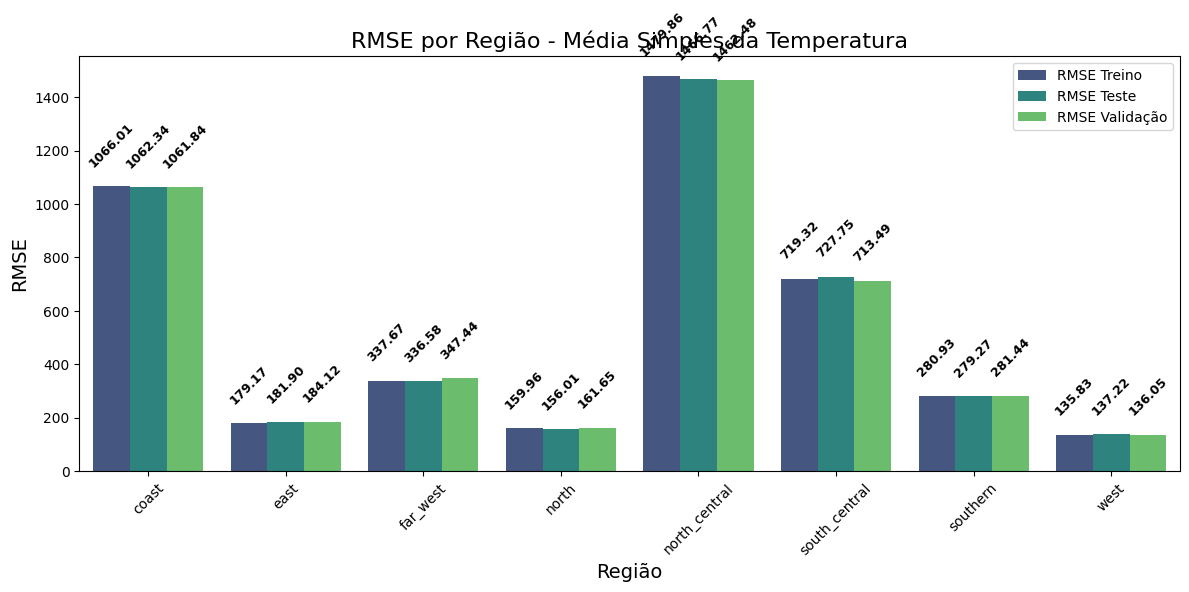

In [77]:
def plot_rmse_por_regiao(df, titulo="RMSE por Região"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Preparar os dados no formato longo
    df_meltado = df.melt(
        id_vars="regiao", 
        value_vars=["RMSE Treino", "RMSE Teste", "RMSE Validação"], 
        var_name="Tipo", 
        value_name="RMSE"
    )

    # Criar o gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_meltado, 
        x="regiao", 
        y="RMSE", 
        hue="Tipo", 
        palette="viridis",
        errorbar=None
    )

    # Remover as bordas pretas das barras
    for bar in ax.patches:
        bar.set_edgecolor("none")

    # Adicionar rótulos com mais espaçamento acima das barras
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 12),  # distância aumentada para 12
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=45,
                    color='black', fontsize=9, fontweight='bold')

    # Ajustes finais do gráfico
    ax.set_title(titulo, fontsize=16)
    ax.set_xlabel("Região", fontsize=14)
    ax.set_ylabel("RMSE", fontsize=14)
    plt.xticks(rotation=45)
    ax.legend(title="", loc="upper right")
    plt.tight_layout()
    plt.show()

# Exemplo de chamada
plot_rmse_por_regiao(tabela1, titulo="RMSE por Região - Média Simples da Temperatura")


# Analisando apenas R²

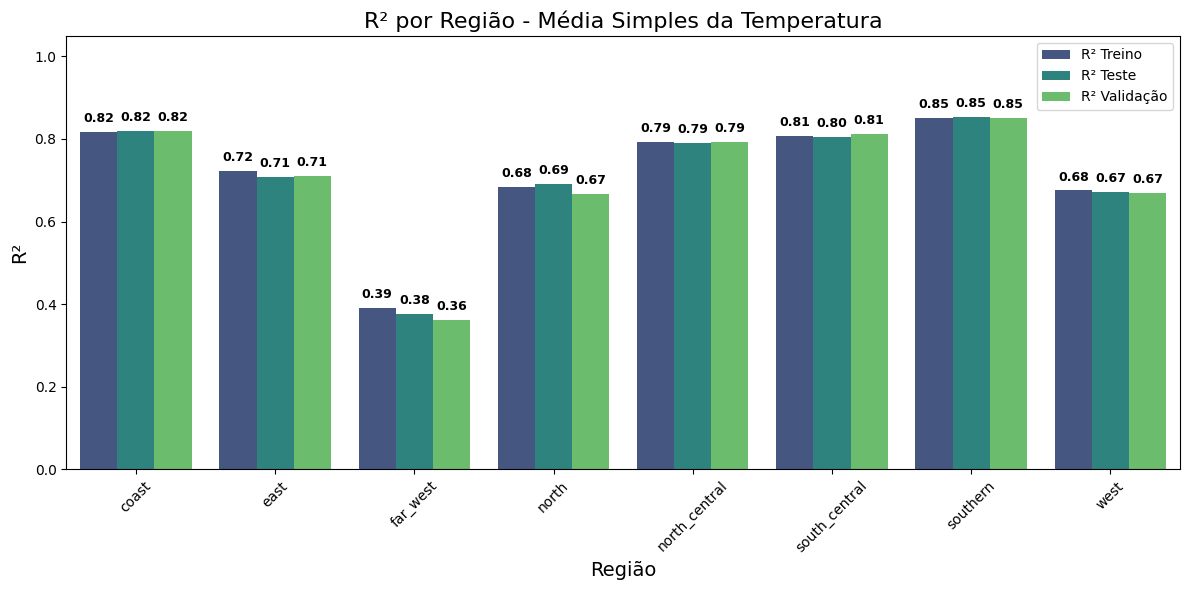

In [78]:
def plot_r2_por_regiao(df, titulo="R² por Região"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Preparar os dados no formato longo
    df_meltado = df.melt(
        id_vars="regiao", 
        value_vars=["R² Treino", "R² Teste", "R² Validação"], 
        var_name="Tipo", 
        value_name="R²"
    )

    # Criar o gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_meltado, 
        x="regiao", 
        y="R²", 
        hue="Tipo", 
        palette="viridis",
        errorbar=None
    )

    # Remover as bordas pretas das barras
    for bar in ax.patches:
        bar.set_edgecolor("none")

    # Adicionar os rótulos acima das barras (não dentro)
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 pontos acima da barra
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='black', fontsize=9, fontweight='bold')

    # Ajustes finais do gráfico
    ax.set_title(titulo, fontsize=16)
    ax.set_xlabel("Região", fontsize=14)
    ax.set_ylabel("R²", fontsize=14)
    plt.xticks(rotation=45)
    ax.legend(title="", loc="upper right")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


plot_r2_por_regiao(tabela1, titulo="R² por Região - Média Simples da Temperatura")


In [67]:
tabela1[(tabela1['regiao']=='far_west')]['R² Validação'].mean()

0.3604005371263168

# Analisando apenas CV

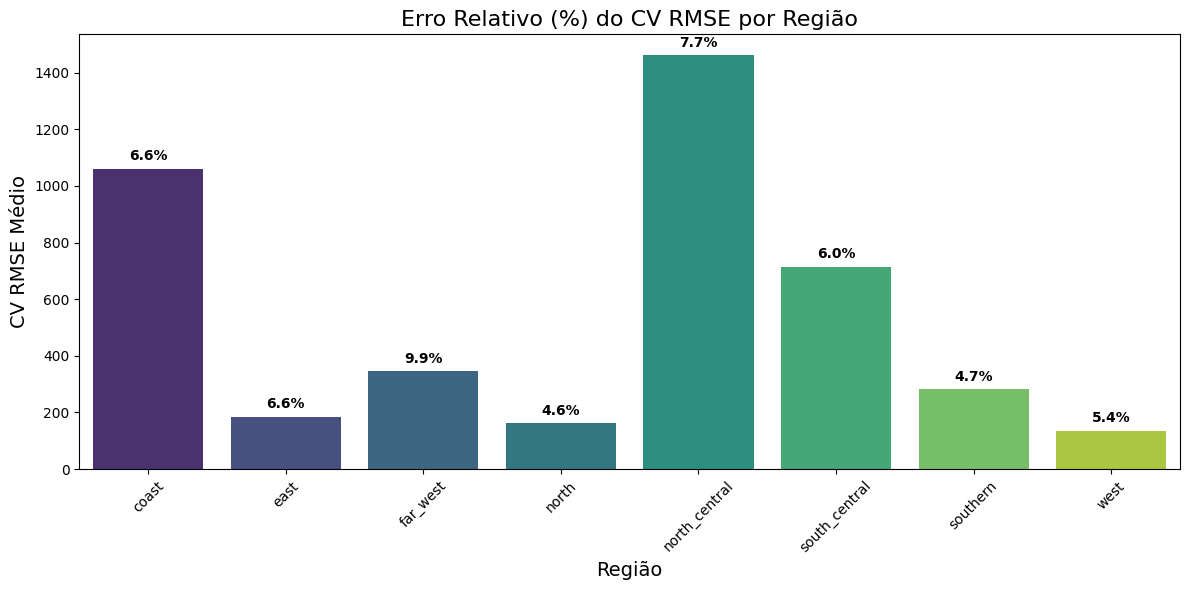

In [79]:
def plot_erro_relativo_por_regiao(df, titulo="Erro Relativo (%) do CV RMSE por Região"):
    # Agrupar os dados por região
    df_grouped = df.groupby("regiao").agg({
        'CV RMSE Médio': 'mean',
        'CV RMSE DP': 'mean'
    }).reset_index()

    # Calcular erro relativo (%) para cada região
    df_grouped["Erro Relativo (%)"] = (df_grouped["CV RMSE DP"] / df_grouped["CV RMSE Médio"]) * 100

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_grouped, x="regiao", y="CV RMSE Médio", palette="viridis", ci=None)

    # Adicionar texto com erro relativo (%) acima de cada barra
    for i, row in df_grouped.iterrows():
        ax.text(i, row["CV RMSE Médio"] + 30, f'{row["Erro Relativo (%)"]:.1f}%', 
                color='black', ha="center", weight="bold")

    # Finalizar gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel("Região", fontsize=14)
    plt.ylabel("CV RMSE Médio", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    
plot_erro_relativo_por_regiao(tabela1, titulo="Erro Relativo (%) do CV RMSE por Região")


In [93]:
df_pond_long[df_pond_long['regiao']=='coast']['carga'].mean()


print(f"df: {df['coast_carga'].mean()}")
print(f"df_long: {df_pond_long[df_pond_long['regiao']=='coast']['carga'].mean()}")


df: 13620.767550500817
df_long: 13715.321477667276
